In [0]:
import csv
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [0]:
# def getData(self, ...):
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import torch.utils.data as data
import numpy as np
import random
import math
import json
import ast
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# ===========================================================
# ================= Data Collecting Class ===================
# ===========================================================
class data_collect():
    def __init__(self, normalize_function = 2, normalize_company = 0, num_range = 1, train_size = 70, 
                 val_size = 15, test_size = 15, start_point_diff = 25, start_point_deviation = 5, 
                 length = 25, pred_length = 5, company_group = True, random_batch = False, 
                 no_change_range = 5, data_points = range(0,14), label_type = 0):
        self.normalize_function = normalize_function
        self.normalize_company = normalize_company
        self.num_range = num_range
        self.train_size = train_size
        self.val_size = val_size
        self.test_size = test_size
        self.start_point_diff = start_point_diff
        self.start_point_deviation = start_point_deviation  
        self.length = length
        self.pred_length = pred_length
        self.no_change_range = no_change_range
        self.company_group = company_group
        self.random_batch = random_batch
        self.data_points = data_points
        self.label_type = label_type


    def format_data(self, data, filename):
        # Read data from .json file
        data = read_from_database_to_list(self.data_points, filename)
        # Get length of data input
        num_data_per_day = len(data[0][0])
        num_companies = len(data[0])
        num_days = len(data)
        
        
        # Add Labels
        data = add_labels(data, self.normalize_function, self.normalize_company, self.num_range, self.pred_length, self.no_change_range, self.data_points, self.label_type)

        # Return splitted the data (3 tensors)
        return split(data, self.train_size, self.val_size, self.test_size, self.start_point_diff, self.start_point_deviation, self.length, self.pred_length)

    def get_label_frequency(self, data, dataset_type):
        data_loader = torch.utils.data.DataLoader(data, batch_size=1)
        zeros = 0
        ones = 0
        half = 0
        for data_item, data_label in data_loader:
            label_to_count = data_label.tolist()
            if (self.label_type == 0):
                if (self.company_group):
                    for i in label_to_count:
                        for j in i:
                            if (j == 0.0):
                                zeros += 1
                            elif (j == 0.5):
                                half += 1
                            elif (j == 1.0):
                                ones += 1
                else:
                    for i in label_to_count:
                        if (i == 0.0):
                            zeros += 1
                        elif (i == 0.5):
                            half += 1
                        elif (i == 1.0):
                            ones += 1
            elif (self.label_type == 1):
                if (self.company_group):
                    for i in label_to_count:
                        for j in i:
                            if (j == 0):
                                zeros += 1
                            elif (j == 1):
                                half += 1
                            elif (j == 2):
                                ones += 1
                else:
                    for i in label_to_count:
                        if (i == 0):
                            zeros += 1
                        elif (i == 1):
                            half += 1
                        elif (i == 2):
                            ones += 1
        print("0.0: " + str(zeros))
        print("0.5: " + str(half))
        print("1.0: " + str(ones))
        print(dataset_type.upper() + " SET LABEL FREQUENCY")
        print("Percent of 0.0 label: ", zeros / (zeros + ones + half))
        print("Percent of 0.5 label: ", half / (zeros + ones + half))
        print("Percent of 1.0 label: ", ones / (zeros + ones + half))
        return None

In [0]:
# ===========================================================
# ================= Random input generator ==================
# ===========================================================

# 9 input per day       --> dim 1
# 165 companies         --> dim 2
# ~763 days             --> dim 3

def random_input_gen(num_data_per_day = 15, num_companies = 160, num_days = 820, data_points = range(0,14)): # random numbers ranging from +- 100,000,000,000 (100 billion)
    data = [[[None for k in range(num_data_per_day)] for j in range(num_companies)] for i in range(num_days)]
    for i in range(num_days):
        for j in range(num_companies):
            for k in range(num_data_per_day):
                data[i][j][k] = random.randint(-100000000000,100000000001)
    # Force numbers to ensure logarithmic normalization works
    data[0][0][0] = 15
    data[0][0][1] = 0.05
    return data

# ============================================================
# ===== Formatting data from .json to dictionary to list =====
# ============================================================

# data_points = list    --> Contains all indexes that are desired
#                                   ~~~ RATIOS ~~~
#                       --> 0 = EPS, 1 = PE ratio, 2 = PPS,
#                       --> 3 = asset turnover 4 = cash flow,
#                       --> 5 = current ratio, 6 = return on equity,
#                       --> 7 = working capital
#                                 ~~~ Stock Data ~~~
#                       --> 8 = Closing stock price,
#                       --> 9 = 14-day moving avg,
#                       --> 10 = 37-day moving average

def read_from_database_to_list(data_points = range(0,14), filename = "data_list_complete.json"):      # Take in raw str, and convert to dictionary, then to list

        with open(filename, "r") as f:              # *******FILE LOCATION/NAME MAY DIFFER ACCORDING TO YOUR REQUIREMENTS******
                content = f.readlines()
        content = [x.strip() for x in content] 
        data = []
        for i in range(0,len(content)):
                data.append(ast.literal_eval(content[i]))       # Converting to dictionary

        data = data[0]
        list_companies = list(data["2019-07-17"].keys())        # All company symbols (anyday works after april 14th 2019)
        list_companies.sort(reverse = False)                    # Sort alphabetically company names

        list_days = list(data.keys())                           # All database days
        list_days = sorted(list_days, key = sorting)            # Sort days in past -> future order
                
        bad_companies = ["WLKP", "VMC", "VRS", "REX", "USLM"]   # These companies data are incomplete. To be removed (not enough data) --> I ADDED "USLM" TO MAKE IT WORK ???
        bad_days = []                                           # List of incomplete days (mostly comprised of days before april 14th 2019)

        for day in list_days:                                   # Delete bad days and companies
                num_companies = len(data[day])
                for company in list_companies:
                        if (company in bad_companies and company in data[day]):
                                del data[day][company]
                        if (num_companies < 160):
                                del data[day]
                                bad_days.append(day)
                                break

        for company in bad_companies:                           # Remove bad companies from company list
                if(company in list_companies):
                        list_companies.remove(company)

        for day in bad_days:                                    # Remove bad days from days list
                list_days.remove(day)
        
        # Give AGX data for April 14th (accidentally omitted)
        # data["2016-04-14"]["AGX"] = data["2016-04-15"]["AGX"]


        num_days = len(data)                                    # Dimensions of data
        num_companies = len(data["2016-04-15"])
        num_data_points = len(data_points)


        list_data = [[[0 for i in range(num_data_points)] for j in range(num_companies)] for k in range(num_days)]

        # Input all data to premade 3D list in order    
        counter_i = 0
        counter_j = 0
        counter_k = 0

        for day in list_days:
                for company in list_companies:
                        for data_point in data_points:
                                list_data[counter_i][counter_j][counter_k] = data[day][company][data_point]
                                counter_k += 1
                        counter_k = 0
                        counter_j += 1
                counter_j = 0
                counter_i += 1
        return list_data            # Type list with all requested data

def sorting(L):                     # Function to sort the days in chronological order
        splitup = L.split('-')
        return splitup[0], splitup[1], splitup[2]

# ===========================================================
# ====================== Normalization ======================
# ===========================================================

# normalize_function = 0    --> No normalization                (Baseline model did not train)
# normalize_function = 1    --> linear normalization            (Baseline model did not train)
# normalize_function = 2    --> logarithmic normalization       (Only function that works for baseline model)

# normalize_company = 0     --> normalize inside each company   (Only normalization that works for baseline model)
# normalize_company = 1     --> normalize across all companies  (Did not work for baseline model)

# range = 0                 --> no limit
# range = 1                 --> [-1, 1]
# range = 2                 --> [ 0, 1]

def normalize_data(data, normalize_function = 0, normalize_company = 0, num_range = 0):

    num_days = len(data)                # Get data dimensions
    num_companies = len(data[0])
    num_data_per_day = len(data[0][0])

    if (normalize_function == 2):       # Take the log 10 of all numbers if we perform logarithmic normalization, else proceed to obtain max/min values
        for i in range(num_days):
            for j in range(num_companies):
                for k in range(num_data_per_day):
                    data[i][j][k] = log_normalization(data[i][j][k])
    
    # 2D list to record each max/min values for each input variable type (the 8 ratios and 3 stock price data)
    maxmin_values = [[0.0,0.0] for i in range(num_data_per_day)]
    div_by_zero_count = 0
    if (normalize_company == 0):
        for i in range(num_companies):
            for j in range(num_days):
                for k in range(num_data_per_day):
                    if (maxmin_values[k][1] < data[j][i][k]):
                        maxmin_values[k][1] = data[j][i][k]
                    if (maxmin_values[k][0] > data[j][i][k]):
                        maxmin_values[k][0] = data[j][i][k]
                    
            # Normalize within a single company
            for j in range(num_days):
                for k in range(num_data_per_day):
                    try:
                        data[j][i][k] = (data[j][i][k] - maxmin_values[k][0]) / (maxmin_values[k][1] - maxmin_values[k][0])
                    except:
                        div_by_zero_count += 1
                        '''
                        print("Error: DIVISION BY ZERO")
                        print("day number:     ", j)
                        print("company number: ", i)
                        print("data index:     ", k)
                        '''

    elif (normalize_company == 1):
        for i in range(num_companies):
            for j in range(num_days):
                for k in range(num_data_per_day):
                    if (maxmin_values[k][1] < data[j][i][k]):
                        maxmin_values[k][1] = data[j][i][k]
                    if (maxmin_values[k][0] > data[j][i][k]):
                        maxmin_values[k][0] = data[j][i][k]
                    
        # Normalize for all data across all companies
        for i in range(num_companies):
            for j in range(num_days):
                for k in range(num_data_per_day):
                    try:
                        data[j][i][k] = (data[j][i][k] - maxmin_values[k][0]) / (maxmin_values[k][1] - maxmin_values[k][0])
                    except:
                        div_by_zero_count += 1
                        '''
                        print("Error: DIVISION BY ZERO")
                        print("day number:     ", j)
                        print("company number: ", i)
                        print("data index:     ", k)
                        '''
    print("Num zero data points: " + str(div_by_zero_count))
    # Normalize the range of the data
    if (num_range == 1):
        for i in range(num_days):
            for j in range(num_companies):
                for k in range(num_data_per_day):
                    data[i][j][k] = (data[i][j][k] - 0.5) * 2.0

    # Return normalize data of type list
    return data

def log_normalization(x):   # Log 10 normalization function
    if (x < 0):
        return -1 * math.log10((-1 * x) + 1)
    else:
        return math.log10(x + 1)

# ===========================================================================
# ========================= Labeling and Formatting =========================
# ===========================================================================

# Label = 1.0  increase in price
# Label = 0.5  no change in price (within percent error margin no_change_range)
# Label = 0.0  decrease in price

def add_labels(data, normalize_function = 2, normalize_company = 0, num_range = 1, pred_length = 5, no_change_range = 5, data_points = range(0,14), label_type = 0):
    # Get dimensions of data
    num_days = len(data)
    num_companies = len(data[0])

    # Get closing price's index
    if (8 not in data_points):
        print("Data does not contain closing stock price")
    price_index = data_points.index(8)
    
    # Label each input with the price 5 working days later
    labeled_data = []
    labeled_data_by_day =[]
    for i in range(num_days):
        if (num_days - i > pred_length):
            for j in range(num_companies):
                 # We can give a label
                if (data[i][j][price_index] > data[i + pred_length][j][price_index]*(1+(no_change_range/100.0))):     # Increase in price
                    label = 1.0
                elif (data[i][j][price_index] < data[i + pred_length][j][price_index]*(1-(no_change_range/100.0))):   # Decrease in price
                    label = 0.0
                else:                           # No change in price (range of allowance)
                    label = 0.5
                if (label != None and label_type == 1):
                    label = int(label*2.0)
                labeled_data_by_day.append(label)
        else:                               # We cannot give a label (no price 5 days ahead available yet)
            print(i)
            data = data[0:i]
            break
 
        labeled_data.append(labeled_data_by_day)
        labeled_data_by_day = []
    
    # Normalize the data
    normalized_data = normalize_data(data, normalize_function, normalize_company, num_range)

    # Add labels to the normalized data
    formatted_data = []
    for day in range(len(normalized_data)):
        formatted_day_data = []
        for company in range(len(normalized_data[day])):
            formatted_day_data.append([normalized_data[day][company], labeled_data[day][company]])
        formatted_data.append(formatted_day_data)

    # Return type list with labels attached
    return formatted_data
  

# ============================================================
# ========================= Batching =========================
# ============================================================

# random = False    --> means first 70% months are training, next 15% are validation
#                       and next 15% are test (assuming percentages did not change)
# random = True     --> randomly pick 70% of months, 15% of months, and 15% of months for 
#                       train/val/test data

# start_point_diff  --> how far apart are the first days in adjacent batchs

# train_size, val_size, test_size   --> percentage of batches to be in each set (must add to 100%)

# start_point_deviation --> the start_point can deviate +- 5 (for example) from the original start_point_diff it was set for

# length        --> how many days in one "item". Days being the days where the market is open for trade

# company_group = True  --> all 160 companies at once
# company_group = False --> 1 company at a time

def split(data, train_size = 70, val_size = 15, test_size = 15, start_point_diff = 25, start_point_deviation = 5, length = 25, pred_length = 5):
    # Ensure percentages add up properly
    random.seed(100)
    if (train_size + val_size + test_size != 100):
        print("ensure train_size + val_size + test_size = 100%")
        return None, None, None

    num_days = len(data)
    num_companies = len(data[0])

    # Use start_point_diff, start_point_deviation, and length to get the day stamps we will cover
    times = []
    time_start = 0
    while((time_start + length + pred_length) < num_days):  # Note that the case where we deal with individual companies, we still give the same start date for each batch item
        times.append(time_start)
        time_start = time_start + start_point_diff
    
    for time in range(0,len(times)):
        if (times[time] != 0):
            times[time] += random.randint(-pred_length,pred_length)
   
    # Batching the data
    # Batch data according to start_point_diff, start_point_deviation, length, and company_group
    data_to_be_split = []
    for i in times:                                    # Iterate through start days
        single_batch = []
        price_label = []
        for day in range(i, i + length):               # Iterate through the length of data per item
            count = 0
            single_day = []
            for companies in range(num_companies):
                for ratios in data[day][companies]:    # Iterate through all companies
                    if (type(ratios) is list):
                        single_day.append(ratios)
                        count += 1
                    elif ((type(ratios) is int or type(ratios) is float) and day == i + length - 1):
                        price_label.append(ratios)
            single_batch.append(single_day)
            
        data_to_be_split.append([single_batch,price_label])

                
    #random.shuffle(data_to_be_split)
        
    train_val_split = int(len(data_to_be_split)*train_size/100.0)
    val_test_split = int(len(data_to_be_split)*(train_size + val_size)/100.0)

    train = data_to_be_split[:train_val_split]
    val = data_to_be_split[train_val_split:val_test_split]
    test = data_to_be_split[val_test_split:]
    company_group = True
    train_data = data_to_tensor(train, company_group)
    val_data = data_to_tensor(val, company_group)
    test_data = data_to_tensor(test, company_group)
    
    # Return 3 tensors
    return train_data, val_data, test_data

def data_to_tensor(data_to_be_split, company_group):
    tensor_data = []
    if (company_group):
      for i in data_to_be_split:
        item_tuple = (torch.FloatTensor(i[0]),torch.as_tensor(i[1]))
        tensor_data.append(item_tuple)
    else:
      for i in data_to_be_split:
        item_tuple = (torch.FloatTensor(i[0]),torch.as_tensor(i[1]))
        tensor_data.append(item_tuple)
    # Return data tensor and label tensor together in a tuple
    return tensor_data

In [0]:
# ========================================
# =============== Get Data ===============             ###### THIS WILL DEPEND ON WHERE YOU PUT YOUR FILE
# ========================================

filename = "/content/gdrive/My Drive/Colab Notebooks/project/data_list_complete.json"

# the file we trianed together and shared. 
# filename = "/content/gdrive/My Drive/Colab Notebooks/project/data_list_complete_random.json"

In [0]:
# Data for all companies at once                       ################ SUPER CRUCIAL

def reFormat(data_all):
    
    new_train_data_all = data_all
    for i, data in enumerate(data_all):      # data is of shape torch.Size([25, 160, 11])
        dataList = data[0].tolist()    # List of the actual data, data[1] is the label
                                       # companyData is of shape torch.Size([160, 11])
        newDataList = []               # Datalist is of shape [25,160,11]
        for companyData in dataList:   # companyData is of shape torch.Size([160, 11])
            new1CompList = []
            for singleCompData in companyData:  # shape of torch.Size([11])
                new1CompList += singleCompData

            newDataList += [new1CompList]  
        newDataTensor = torch.tensor(newDataList)

        new_train_data_all[i] = (newDataTensor, data[1])
    return new_train_data_all
  
data_all_company = data_collect(normalize_function = 2, # Don't touch
                                normalize_company = 0,  # Don't touch
                                num_range = 2,          # Don't touch
                                train_size = 70, 
                                val_size = 15, 
                                test_size = 15, 
                                start_point_diff = 1,       # Changes how much data you have, 1 (smallest) gives most data
                                start_point_deviation = 0,  # I can explain this with a diagram if you want
                                length = 25,                # 
                                pred_length = 5,            # If you want evenly split data, pred_length = 1 corresponrs to no_change_range = 0.65, ana pred_length = 5 to no_change_range = 1.85
                                company_group = True,       # KEEP TRUE IF YOU WANT ALL COMPANIES AT ONCE
                                random_batch = False,       # Does nothing
                                no_change_range = 1.70,
                                data_points = range(0,14),  # Can be a list of whatever data points you want. 
                                label_type = 0)             # Keep 0 for now. 1 (cross entropy) didn't work. Will fix soon

train_data_all, val_data_all, test_data_all = data_all_company.format_data(True, filename) ###### DID NOT USE data_loader on these (for the reason of flexible batching)
print(train_data_all)
train_data_all = reFormat(train_data_all)
val_data_all = reFormat(val_data_all)
test_data_all = reFormat(test_data_all)
print(len(train_data_all))
print(train_data_all[0][0].shape)



825
Num zero data points: 0
[(tensor([[[0.5228, 0.1987, 0.8995,  ..., 0.8450, 0.9092, 0.0652],
         [0.8083, 0.7546, 0.7319,  ..., 0.5415, 0.5382, 0.1179],
         [0.8913, 0.7645, 0.8298,  ..., 0.6860, 0.6401, 0.0427],
         ...,
         [0.5249, 0.3809, 0.0669,  ..., 0.5850, 0.5025, 0.7545],
         [0.4775, 0.2495, 0.4909,  ..., 0.1605, 0.2041, 1.0000],
         [0.4425, 0.2952, 0.3938,  ..., 0.9703, 0.9474, 0.0000]],

        [[0.5228, 0.1987, 0.8995,  ..., 0.8835, 0.8797, 0.0647],
         [0.8083, 0.7546, 0.7319,  ..., 0.5992, 0.5646, 0.1171],
         [0.8913, 0.7645, 0.8298,  ..., 0.8640, 0.7474, 0.0416],
         ...,
         [0.5249, 0.3809, 0.0669,  ..., 0.3219, 0.4150, 0.7580],
         [0.4775, 0.2495, 0.4909,  ..., 0.0825, 0.1478, 1.0000],
         [0.4425, 0.2952, 0.3938,  ..., 0.9689, 0.9723, 0.0000]],

        [[0.5228, 0.1987, 0.8995,  ..., 0.8514, 0.8719, 0.0645],
         [0.8083, 0.7546, 0.7319,  ..., 0.7681, 0.6473, 0.1158],
         [0.8913, 0.7645, 0.

In [0]:
# with 14 instead 11 
class pred_LSTM_v2(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, batch_size):
        super(pred_LSTM_v2, self).__init__()
        #self.emb = --> from the data function, the data come in in right shape
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first = True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self,x):
        # Format to be proper input pf shape [batch_zise, seq = 25, size = 162*11]
        #inp = self.emb(x) --> from the data function, the data come in in right shape
        inp = x.cuda()
        # Shape of the hidden layer and cell state should have 
        # shape of [batch_size, sequence length(25), hidden_size]
        h0 = torch.zeros(self.batch_size, x.size(0), self.hidden_size).cuda()
        c0 = torch.zeros(self.batch_size, x.size(0),  self.hidden_size).cuda()
        
        #Shape of the LSTM output will be [batch_size, sequence length(25), hidden_size]
        out, (h_new, c_new) = self.lstm(inp, (h0,c0))
        out = self.fc(out[:,-1,:]).cuda()
        return out
        

In [0]:
import time
def evaluate_validation(model, batch_size, all_data, criterion):
    total_loss = 0.0
    correct = 0.0
    total = 0
    count = 0

    all_data = batched_Data(all_data, batch_size)
    
    for data, labels in all_data:
        count += 1
        output = model(data).cuda()
        labels = labels.cuda()
        loss = criterion(output, labels).cuda()
        #print(loss)
        #print(total_loss)
        total_loss += loss.item()
        
        pred = output
        '''
        print(labels.shape)
        print(output.shape)
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probabilit
        print(pred.shape)
        '''
        for batch in range(batch_size):
            for i,out in enumerate(pred[batch]):
                if out <= 0.33:
                    pred[batch][i] = 0
                elif out >= 0.67:
                    pred[batch][i] = 1
                elif 0.33 < out < 0.67:
                    pred[batch][i] = 0.5
        '''
        print(labels)        
        print(pred)  
        print(labels.view_as(pred))
        print(pred.eq(labels.view_as(pred)))
        '''
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += data.shape[0]*160
    accuracy = correct / total
    loss = total_loss / count
    #print(accuracy, loss)
    return accuracy, loss


def get_accuracy(model, all_data):
    correct, total = 0, 0
    for data, labels in all_data:
        output = model(data).cuda()
        labels = labels.cuda()
        pred = output
        '''
        print(labels.shape)
        print(output.shape)
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probabilit
        print(pred.shape)
        '''
        
        for batch in range(data.shape[0]):
            for i,out in enumerate(pred[batch]):
                if out <= 0.33:
                    pred[batch][i] = 0.0
                elif out >= 0.67:
                    pred[batch][i] = 1.0
                elif 0.33 < out < 0.67:
                    pred[batch][i] = 0.5
        '''
        print(labels)        
        print(pred)  
        print(labels.view_as(pred))
        print(pred.eq(labels.view_as(pred)))
        '''
        correct += pred.eq(labels.view_as(pred)).sum().item()
        #print('correct:{}'.format(correct))
        
        total += data.shape[0]*160
        #print('total:{}'.format(total))
    return correct / total

def batched_Data(data, batch_size):
    dataLen = len(data)
    lenList = [i for i in range(dataLen)]
    random.shuffle(lenList)
    i = 0
    new_tot_list = []
    while i+batch_size <= dataLen:
      new_dataList_per_batch = []
      new_labelList_per_batch = []
      
      for j in range(i,i+batch_size):
          if j == dataLen:
              break
          new_data = data[lenList[j]][0].tolist()
          new_label = data[lenList[j]][1].tolist()
          new_dataList_per_batch.append(new_data)
          new_labelList_per_batch.append(new_label)
      #print(len(new_dataList_per_batch))
      #print(len(new_dataList_per_batch[0]))
      #print(len(new_dataList_per_batch[0][0]))

      new_tot_list += [(torch.tensor(new_dataList_per_batch), torch.tensor(new_labelList_per_batch))]
      i = i+batch_size
    return new_tot_list
    

def train_LSTM_network(model, train, valid, batch_size, num_epochs, lr):
    criterion = nn.MSELoss()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    #train = torch.utils.data.DataLoader(old_train, batch_size)#, shuffle=True)
    #valid = torch.utils.data.DataLoader(valid, batch_size, shuffle=True)
    losses, train_acc, valid_acc, val_losses = [], [], [], []
    epochs = []
    start = time.time()
    for epoch in range(num_epochs):   # need to be able to do random batch
        print(epoch)
        new_train = batched_Data(train, batch_size)
        for i, (tweets, labels) in enumerate(new_train):
            optimizer.zero_grad()
            pred = model(tweets).cuda()
            labels = labels.cuda()
            #print(labels)
            loss = criterion(pred, labels).cuda()
            loss.backward()
            optimizer.step()

        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, new_train))
        val_acc, val_loss = evaluate_validation(model,  batch_size, valid,criterion)
        val_losses.append(val_loss)
        valid_acc.append(val_acc)
        
        print("Epoch %d; Loss %f; Train Acc %f; Val_loss %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], val_loss, valid_acc[-1]))
    end = time.time()
    print('time: {}'.format(end - start))
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.plot(val_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()




0
Epoch 1; Loss 0.164970; Train Acc 0.352917; Val_loss 0.190695; Val Acc 0.268813
1
Epoch 2; Loss 0.162997; Train Acc 0.354664; Val_loss 0.189603; Val Acc 0.264250
2
Epoch 3; Loss 0.153782; Train Acc 0.356447; Val_loss 0.195870; Val Acc 0.265625
3
Epoch 4; Loss 0.146296; Train Acc 0.363715; Val_loss 0.206221; Val Acc 0.260813
4
Epoch 5; Loss 0.158069; Train Acc 0.367859; Val_loss 0.203362; Val Acc 0.264562
5
Epoch 6; Loss 0.144520; Train Acc 0.376840; Val_loss 0.196003; Val Acc 0.281625
6
Epoch 7; Loss 0.147794; Train Acc 0.392269; Val_loss 0.202931; Val Acc 0.290250
7
Epoch 8; Loss 0.144766; Train Acc 0.415174; Val_loss 0.224438; Val Acc 0.293812
8
Epoch 9; Loss 0.143039; Train Acc 0.413819; Val_loss 0.205499; Val Acc 0.288187
9
Epoch 10; Loss 0.132615; Train Acc 0.437141; Val_loss 0.205628; Val Acc 0.292750
10
Epoch 11; Loss 0.134882; Train Acc 0.451458; Val_loss 0.205100; Val Acc 0.295375
11
Epoch 12; Loss 0.138761; Train Acc 0.464398; Val_loss 0.226976; Val Acc 0.293875
12
Epoch 13

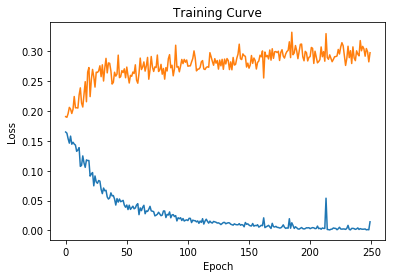

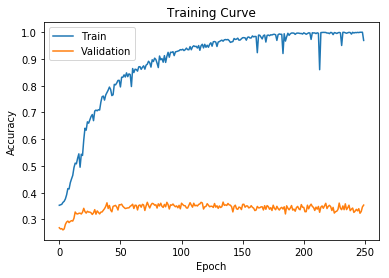

In [0]:
# no change = 1.8, 
model = pred_LSTM_v2(2240, 1024, 160, 1).cuda()
train_LSTM_network(model, train_data_all, val_data_all, batch_size = 20, num_epochs = 250, lr=0.0001)

0
Epoch 1; Loss 0.167866; Train Acc 0.334132; Val Acc 0.344313
1
Epoch 2; Loss 0.166240; Train Acc 0.334653; Val Acc 0.344750
2
Epoch 3; Loss 0.165683; Train Acc 0.335787; Val Acc 0.344813
3
Epoch 4; Loss 0.164137; Train Acc 0.338530; Val Acc 0.347125
4
Epoch 5; Loss 0.163115; Train Acc 0.341412; Val Acc 0.348438
5
Epoch 6; Loss 0.161897; Train Acc 0.346493; Val Acc 0.350562
6
Epoch 7; Loss 0.160253; Train Acc 0.352326; Val Acc 0.354000
7
Epoch 8; Loss 0.158512; Train Acc 0.360845; Val Acc 0.359812
8
Epoch 9; Loss 0.156703; Train Acc 0.367593; Val Acc 0.363750
9
Epoch 10; Loss 0.154731; Train Acc 0.376528; Val Acc 0.368937
10
Epoch 11; Loss 0.153044; Train Acc 0.383762; Val Acc 0.372750
11
Epoch 12; Loss 0.150998; Train Acc 0.393553; Val Acc 0.376875
12
Epoch 13; Loss 0.149104; Train Acc 0.403565; Val Acc 0.384625
13
Epoch 14; Loss 0.147222; Train Acc 0.414514; Val Acc 0.389937
14
Epoch 15; Loss 0.144540; Train Acc 0.425961; Val Acc 0.395500
15
Epoch 16; Loss 0.141532; Train Acc 0.4373

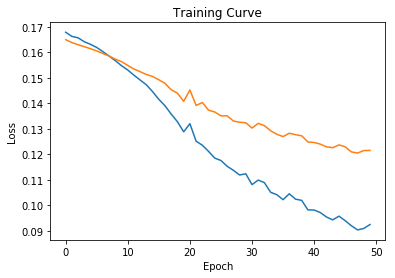

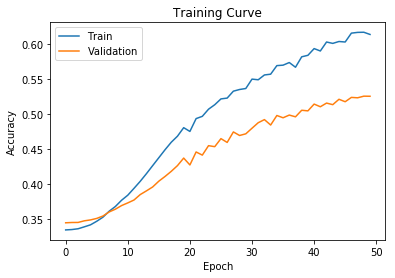

In [0]:
# no change = 1.8, 
model = pred_LSTM_v2(2240, 200, 160, 1).cuda()
train_LSTM_network(model, train_data_all, val_data_all, batch_size = 20, num_epochs = 50, lr=0.0001)

0
Epoch 1; Loss 0.163228; Train Acc 0.335000; Val Acc 0.350125
1
Epoch 2; Loss 0.174945; Train Acc 0.334606; Val Acc 0.341500
2
Epoch 3; Loss 0.171047; Train Acc 0.332465; Val Acc 0.340687
3
Epoch 4; Loss 0.161254; Train Acc 0.337025; Val Acc 0.346500
4
Epoch 5; Loss 0.158836; Train Acc 0.339838; Val Acc 0.358250
5
Epoch 6; Loss 0.155446; Train Acc 0.342488; Val Acc 0.356875
6
Epoch 7; Loss 0.156308; Train Acc 0.350440; Val Acc 0.356938
7
Epoch 8; Loss 0.160131; Train Acc 0.354942; Val Acc 0.350438
8
Epoch 9; Loss 0.149595; Train Acc 0.368148; Val Acc 0.362312
9
Epoch 10; Loss 0.146918; Train Acc 0.373692; Val Acc 0.363812
10
Epoch 11; Loss 0.144715; Train Acc 0.386667; Val Acc 0.379875
11
Epoch 12; Loss 0.139617; Train Acc 0.396759; Val Acc 0.371500
12
Epoch 13; Loss 0.139351; Train Acc 0.407396; Val Acc 0.376437
13
Epoch 14; Loss 0.130557; Train Acc 0.412315; Val Acc 0.384125
14
Epoch 15; Loss 0.137209; Train Acc 0.416424; Val Acc 0.399625
15
Epoch 16; Loss 0.152011; Train Acc 0.4204

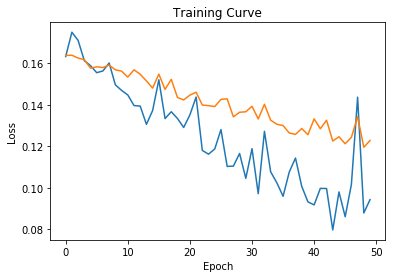

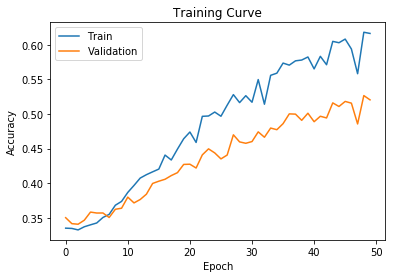

In [0]:
# no change = 1.8, 
model = pred_LSTM_v2(2240, 200, 160, 1).cuda()
train_LSTM_network(model, train_data_all, val_data_all, batch_size = 20, num_epochs = 50, lr=0.0001)

0
Epoch 1; Loss 0.159906; Train Acc 0.334931; Val Acc 0.345500
1
Epoch 2; Loss 0.163835; Train Acc 0.332384; Val Acc 0.341500
2
Epoch 3; Loss 0.154953; Train Acc 0.333368; Val Acc 0.342562
3
Epoch 4; Loss 0.163026; Train Acc 0.334225; Val Acc 0.348000
4
Epoch 5; Loss 0.163440; Train Acc 0.337350; Val Acc 0.342687
5
Epoch 6; Loss 0.163211; Train Acc 0.342917; Val Acc 0.345438
6
Epoch 7; Loss 0.152305; Train Acc 0.362512; Val Acc 0.348125
7
Epoch 8; Loss 0.170251; Train Acc 0.352917; Val Acc 0.352187
8
Epoch 9; Loss 0.145139; Train Acc 0.363438; Val Acc 0.360250
9
Epoch 10; Loss 0.148167; Train Acc 0.378831; Val Acc 0.364438
10
Epoch 11; Loss 0.138265; Train Acc 0.393981; Val Acc 0.379063
11
Epoch 12; Loss 0.140733; Train Acc 0.394850; Val Acc 0.377688
12
Epoch 13; Loss 0.140710; Train Acc 0.414074; Val Acc 0.388375
13
Epoch 14; Loss 0.136949; Train Acc 0.418426; Val Acc 0.381563
14
Epoch 15; Loss 0.132745; Train Acc 0.435162; Val Acc 0.387562
15
Epoch 16; Loss 0.146717; Train Acc 0.4298

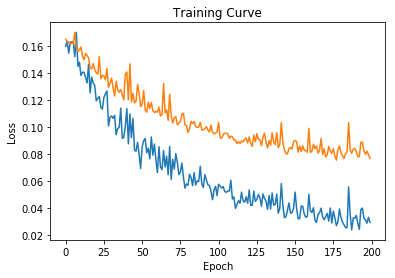

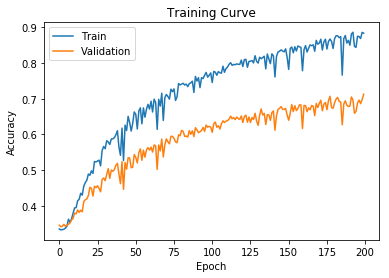

In [0]:

model = pred_LSTM_v2(2240, 200, 160, 1).cuda()
train_LSTM_network(model, train_data_all, val_data_all, batch_size = 20, num_epochs = 200, lr=0.0002)

0
Epoch 1; Loss 0.166919; Train Acc 0.335984; Val Acc 0.355000
1
Epoch 2; Loss 0.166098; Train Acc 0.332801; Val Acc 0.348062
2
Epoch 3; Loss 0.160478; Train Acc 0.335359; Val Acc 0.354875
3
Epoch 4; Loss 0.161050; Train Acc 0.334653; Val Acc 0.346313
4
Epoch 5; Loss 0.159228; Train Acc 0.341609; Val Acc 0.355375
5
Epoch 6; Loss 0.155239; Train Acc 0.340660; Val Acc 0.349062
6
Epoch 7; Loss 0.161100; Train Acc 0.352141; Val Acc 0.349000
7
Epoch 8; Loss 0.156261; Train Acc 0.369259; Val Acc 0.373812
8
Epoch 9; Loss 0.152719; Train Acc 0.366424; Val Acc 0.358938
9
Epoch 10; Loss 0.155895; Train Acc 0.390243; Val Acc 0.369250
10
Epoch 11; Loss 0.150549; Train Acc 0.392303; Val Acc 0.371125
11
Epoch 12; Loss 0.145761; Train Acc 0.400463; Val Acc 0.385375
12
Epoch 13; Loss 0.149413; Train Acc 0.412789; Val Acc 0.380563
13
Epoch 14; Loss 0.135322; Train Acc 0.423877; Val Acc 0.395375
14
Epoch 15; Loss 0.139259; Train Acc 0.435660; Val Acc 0.397062
15
Epoch 16; Loss 0.122685; Train Acc 0.4583

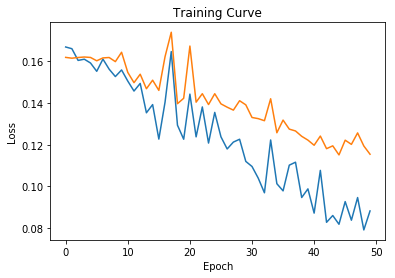

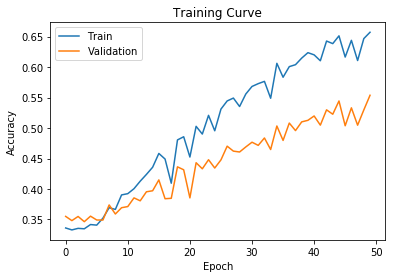

In [0]:

model = pred_LSTM_v2(2240, 224, 160, 1).cuda()
train_LSTM_network(model, train_data_all, val_data_all, batch_size = 20, num_epochs = 50, lr=0.0002)

0
Epoch 1; Loss 0.170592; Train Acc 0.335741; Val Acc 0.344000
1
Epoch 2; Loss 0.153346; Train Acc 0.334259; Val Acc 0.346938
2
Epoch 3; Loss 0.180964; Train Acc 0.334294; Val Acc 0.348000
3
Epoch 4; Loss 0.165607; Train Acc 0.337303; Val Acc 0.350562
4
Epoch 5; Loss 0.169651; Train Acc 0.342940; Val Acc 0.352500
5
Epoch 6; Loss 0.162826; Train Acc 0.339340; Val Acc 0.342813
6
Epoch 7; Loss 0.154396; Train Acc 0.348727; Val Acc 0.353125
7
Epoch 8; Loss 0.152420; Train Acc 0.371238; Val Acc 0.362438
8
Epoch 9; Loss 0.158016; Train Acc 0.388553; Val Acc 0.388313
9
Epoch 10; Loss 0.149048; Train Acc 0.373669; Val Acc 0.365750
10
Epoch 11; Loss 0.144937; Train Acc 0.395266; Val Acc 0.380688
11
Epoch 12; Loss 0.147021; Train Acc 0.401921; Val Acc 0.385125
12
Epoch 13; Loss 0.137772; Train Acc 0.422627; Val Acc 0.385875
13
Epoch 14; Loss 0.152871; Train Acc 0.422396; Val Acc 0.393000
14
Epoch 15; Loss 0.140158; Train Acc 0.427998; Val Acc 0.393062
15
Epoch 16; Loss 0.131496; Train Acc 0.4432

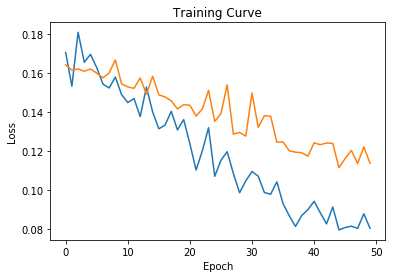

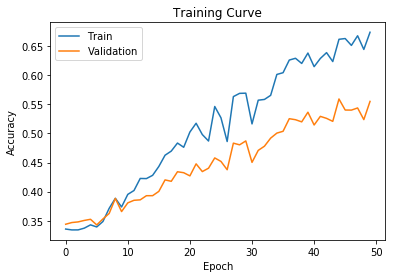

In [0]:

model = pred_LSTM_v2(2240, 256, 160, 1).cuda()
train_LSTM_network(model, train_data_all, val_data_all, batch_size = 20, num_epochs = 50, lr=0.0002)

0
Epoch 1; Loss 0.157163; Train Acc 0.334352; Val Acc 0.352875
1
Epoch 2; Loss 0.172571; Train Acc 0.331609; Val Acc 0.344875
2
Epoch 3; Loss 0.159198; Train Acc 0.336806; Val Acc 0.345562
3
Epoch 4; Loss 0.159088; Train Acc 0.337303; Val Acc 0.342500
4
Epoch 5; Loss 0.153331; Train Acc 0.339294; Val Acc 0.346250
5
Epoch 6; Loss 0.154777; Train Acc 0.341725; Val Acc 0.356500
6
Epoch 7; Loss 0.156882; Train Acc 0.351782; Val Acc 0.359750
7
Epoch 8; Loss 0.154445; Train Acc 0.357581; Val Acc 0.360125
8
Epoch 9; Loss 0.153056; Train Acc 0.376493; Val Acc 0.370250
9
Epoch 10; Loss 0.141593; Train Acc 0.387801; Val Acc 0.367875
10
Epoch 11; Loss 0.143955; Train Acc 0.398241; Val Acc 0.375312
11
Epoch 12; Loss 0.140616; Train Acc 0.397859; Val Acc 0.383250
12
Epoch 13; Loss 0.146067; Train Acc 0.409653; Val Acc 0.396562
13
Epoch 14; Loss 0.138221; Train Acc 0.421782; Val Acc 0.393375
14
Epoch 15; Loss 0.144884; Train Acc 0.424954; Val Acc 0.387688
15
Epoch 16; Loss 0.141124; Train Acc 0.4364

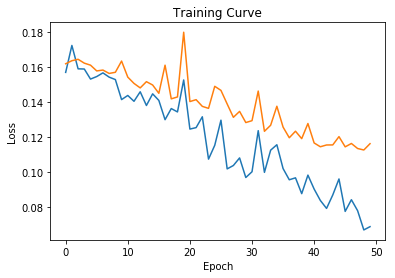

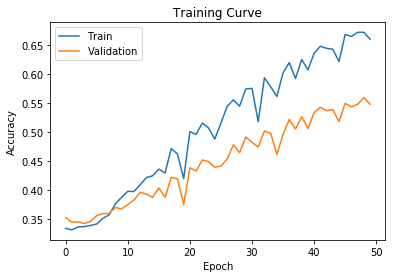

In [0]:

model = pred_LSTM_v2(2240, 300, 160, 1).cuda()
train_LSTM_network(model, train_data_all, val_data_all, batch_size = 20, num_epochs = 50, lr=0.0002)

0
Epoch 1; Loss 0.171043; Train Acc 0.332836; Val Acc 0.342125
1
Epoch 2; Loss 0.163684; Train Acc 0.334826; Val Acc 0.343813
2
Epoch 3; Loss 0.162209; Train Acc 0.336782; Val Acc 0.346438
3
Epoch 4; Loss 0.160970; Train Acc 0.339861; Val Acc 0.352312
4
Epoch 5; Loss 0.159346; Train Acc 0.342512; Val Acc 0.344438
5
Epoch 6; Loss 0.180552; Train Acc 0.364132; Val Acc 0.371312
6
Epoch 7; Loss 0.147489; Train Acc 0.349282; Val Acc 0.355687
7
Epoch 8; Loss 0.165424; Train Acc 0.372523; Val Acc 0.375312
8
Epoch 9; Loss 0.150911; Train Acc 0.366308; Val Acc 0.368312
9
Epoch 10; Loss 0.154498; Train Acc 0.380521; Val Acc 0.366375
10
Epoch 11; Loss 0.147638; Train Acc 0.375023; Val Acc 0.371750
11
Epoch 12; Loss 0.151551; Train Acc 0.394201; Val Acc 0.384437
12
Epoch 13; Loss 0.153064; Train Acc 0.404329; Val Acc 0.368812
13
Epoch 14; Loss 0.156920; Train Acc 0.411887; Val Acc 0.394375
14
Epoch 15; Loss 0.127807; Train Acc 0.431956; Val Acc 0.398313
15
Epoch 16; Loss 0.132456; Train Acc 0.4497

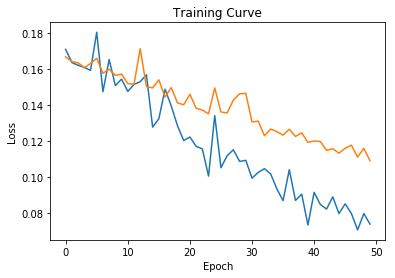

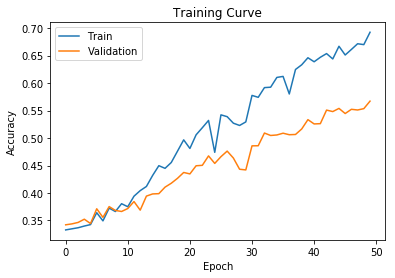

In [0]:

model = pred_LSTM_v2(2240, 400, 160, 1).cuda()
train_LSTM_network(model, train_data_all, val_data_all, batch_size = 20, num_epochs = 50, lr=0.0002)

0
Epoch 1; Loss 0.171822; Train Acc 0.332188; Val Acc 0.339813
1
Epoch 2; Loss 0.163247; Train Acc 0.336100; Val Acc 0.342438
2
Epoch 3; Loss 0.159829; Train Acc 0.340347; Val Acc 0.356812
3
Epoch 4; Loss 0.153593; Train Acc 0.339803; Val Acc 0.350750
4
Epoch 5; Loss 0.160532; Train Acc 0.349919; Val Acc 0.359812
5
Epoch 6; Loss 0.168683; Train Acc 0.348148; Val Acc 0.354875
6
Epoch 7; Loss 0.160957; Train Acc 0.354942; Val Acc 0.358750
7
Epoch 8; Loss 0.154220; Train Acc 0.364583; Val Acc 0.363375
8
Epoch 9; Loss 0.151862; Train Acc 0.384005; Val Acc 0.375250
9
Epoch 10; Loss 0.149139; Train Acc 0.396794; Val Acc 0.383500
10
Epoch 11; Loss 0.146906; Train Acc 0.400903; Val Acc 0.377437
11
Epoch 12; Loss 0.139174; Train Acc 0.418553; Val Acc 0.395375
12
Epoch 13; Loss 0.140041; Train Acc 0.426748; Val Acc 0.396625
13
Epoch 14; Loss 0.133194; Train Acc 0.439479; Val Acc 0.410813
14
Epoch 15; Loss 0.120457; Train Acc 0.470810; Val Acc 0.422375
15
Epoch 16; Loss 0.136867; Train Acc 0.4734

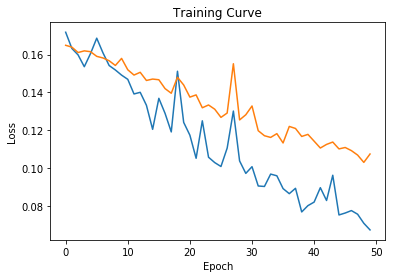

In [0]:

model = pred_LSTM_v2(2240, 400, 160, 1).cuda()
train_LSTM_network(model, train_data_all, val_data_all, batch_size = 20, num_epochs = 50, lr=0.0001)

0
Epoch 1; Loss 0.164982; Train Acc 0.337465; Val Acc 0.353125
1
Epoch 2; Loss 0.167065; Train Acc 0.336192; Val Acc 0.340250
2
Epoch 3; Loss 0.164426; Train Acc 0.335463; Val Acc 0.354375
3
Epoch 4; Loss 0.164104; Train Acc 0.338333; Val Acc 0.346313
4
Epoch 5; Loss 0.151871; Train Acc 0.345683; Val Acc 0.350313
5
Epoch 6; Loss 0.150071; Train Acc 0.361076; Val Acc 0.356500
6
Epoch 7; Loss 0.155527; Train Acc 0.371331; Val Acc 0.362750
7
Epoch 8; Loss 0.152662; Train Acc 0.381736; Val Acc 0.364625
8
Epoch 9; Loss 0.159142; Train Acc 0.396238; Val Acc 0.372937
9
Epoch 10; Loss 0.144550; Train Acc 0.409410; Val Acc 0.395625
10
Epoch 11; Loss 0.128937; Train Acc 0.437604; Val Acc 0.402813
11
Epoch 12; Loss 0.137190; Train Acc 0.435856; Val Acc 0.412375
12
Epoch 13; Loss 0.140882; Train Acc 0.453924; Val Acc 0.413375
13
Epoch 14; Loss 0.129662; Train Acc 0.467373; Val Acc 0.423000
14
Epoch 15; Loss 0.117394; Train Acc 0.476319; Val Acc 0.433375
15
Epoch 16; Loss 0.134268; Train Acc 0.4763

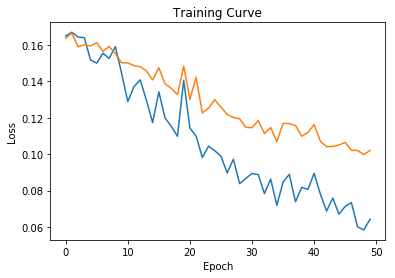

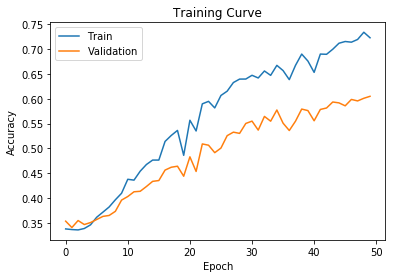

In [0]:

model = pred_LSTM_v2(2240, 500, 160, 1).cuda()
train_LSTM_network(model, train_data_all, val_data_all, batch_size = 20, num_epochs = 50, lr=0.0001)

0
Epoch 1; Loss 0.166933; Train Acc 0.332674; Val Acc 0.350000
1
Epoch 2; Loss 0.170829; Train Acc 0.334039; Val Acc 0.345313
2
Epoch 3; Loss 0.161122; Train Acc 0.337049; Val Acc 0.344062
3
Epoch 4; Loss 0.166202; Train Acc 0.342882; Val Acc 0.353875
4
Epoch 5; Loss 0.164590; Train Acc 0.344387; Val Acc 0.358063
5
Epoch 6; Loss 0.154769; Train Acc 0.349155; Val Acc 0.353187
6
Epoch 7; Loss 0.151928; Train Acc 0.364051; Val Acc 0.355375
7
Epoch 8; Loss 0.150936; Train Acc 0.372454; Val Acc 0.371063
8
Epoch 9; Loss 0.144987; Train Acc 0.385718; Val Acc 0.366500
9
Epoch 10; Loss 0.168974; Train Acc 0.395451; Val Acc 0.378937
10
Epoch 11; Loss 0.139837; Train Acc 0.422917; Val Acc 0.397062
11
Epoch 12; Loss 0.145863; Train Acc 0.429213; Val Acc 0.403562
12
Epoch 13; Loss 0.136177; Train Acc 0.453206; Val Acc 0.413750
13
Epoch 14; Loss 0.132139; Train Acc 0.465370; Val Acc 0.423750
14
Epoch 15; Loss 0.134176; Train Acc 0.477697; Val Acc 0.430500
15
Epoch 16; Loss 0.133003; Train Acc 0.4823

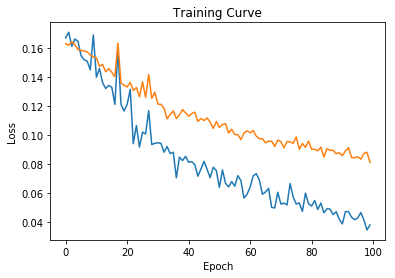

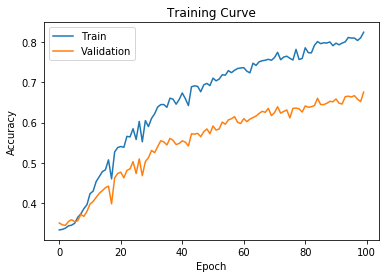

In [0]:

model = pred_LSTM_v2(2240, 400, 160, 1).cuda()
train_LSTM_network(model, train_data_all, val_data_all, batch_size = 20, num_epochs = 100, lr=0.0001)

In [0]:

model = pred_LSTM_v2(2240, 1000, 160, 1).cuda()
train_LSTM_network(model, train_data_all, val_data_all, batch_size = 20, num_epochs = 50, lr=0.0001)

0
Epoch 1; Loss 0.168410; Train Acc 0.336227; Val Acc 0.350875
1
Epoch 2; Loss 0.167850; Train Acc 0.338646; Val Acc 0.352687
2
Epoch 3; Loss 0.162087; Train Acc 0.340752; Val Acc 0.345938
3
Epoch 4; Loss 0.165423; Train Acc 0.349016; Val Acc 0.354375
4
Epoch 5; Loss 0.147410; Train Acc 0.338299; Val Acc 0.357125
5
Epoch 6; Loss 0.157486; Train Acc 0.349363; Val Acc 0.355938
6
Epoch 7; Loss 0.155406; Train Acc 0.386644; Val Acc 0.368188
7
Epoch 8; Loss 0.142538; Train Acc 0.373310; Val Acc 0.365438
8
Epoch 9; Loss 0.151838; Train Acc 0.388356; Val Acc 0.381437
9
Epoch 10; Loss 0.145657; Train Acc 0.409421; Val Acc 0.400187
10
Epoch 11; Loss 0.149384; Train Acc 0.405336; Val Acc 0.390062
11
Epoch 12; Loss 0.155083; Train Acc 0.414074; Val Acc 0.396125
12
Epoch 13; Loss 0.138928; Train Acc 0.447512; Val Acc 0.405187
13
Epoch 14; Loss 0.133891; Train Acc 0.457986; Val Acc 0.421375
14
Epoch 15; Loss 0.134846; Train Acc 0.474687; Val Acc 0.421312
15
Epoch 16; Loss 0.129423; Train Acc 0.4811

In [0]:

model = pred_LSTM_v2(2240, 1024, 160, 1).cuda()
train_LSTM_network(model, train_data_all, val_data_all, batch_size = 20, num_epochs = 50, lr=0.0001)

0
Epoch 1; Loss 0.157528; Train Acc 0.335370; Val Acc 0.345562
1
Epoch 2; Loss 0.164387; Train Acc 0.336389; Val Acc 0.350187
2
Epoch 3; Loss 0.159782; Train Acc 0.333391; Val Acc 0.355750
3
Epoch 4; Loss 0.166831; Train Acc 0.338438; Val Acc 0.346313
4
Epoch 5; Loss 0.157454; Train Acc 0.341956; Val Acc 0.347687
5
Epoch 6; Loss 0.156675; Train Acc 0.366921; Val Acc 0.361312
6
Epoch 7; Loss 0.168235; Train Acc 0.356713; Val Acc 0.360812
7
Epoch 8; Loss 0.147177; Train Acc 0.382512; Val Acc 0.365687
8
Epoch 9; Loss 0.145424; Train Acc 0.399144; Val Acc 0.374000
9
Epoch 10; Loss 0.152104; Train Acc 0.396424; Val Acc 0.384313
10
Epoch 11; Loss 0.141664; Train Acc 0.414618; Val Acc 0.391562
11
Epoch 12; Loss 0.133318; Train Acc 0.434688; Val Acc 0.400125
12
Epoch 13; Loss 0.139027; Train Acc 0.436794; Val Acc 0.404187
13
Epoch 14; Loss 0.133285; Train Acc 0.455035; Val Acc 0.405062
14
Epoch 15; Loss 0.126695; Train Acc 0.479664; Val Acc 0.424187
15
Epoch 16; Loss 0.116618; Train Acc 0.4933

0
Epoch 1; Loss 0.168934; Train Acc 0.334514; Val_loss 0.165561; Val Acc 0.345938
1
Epoch 2; Loss 0.164450; Train Acc 0.335104; Val_loss 0.163637; Val Acc 0.342875
2
Epoch 3; Loss 0.164727; Train Acc 0.335579; Val_loss 0.161507; Val Acc 0.349938
3
Epoch 4; Loss 0.160965; Train Acc 0.339178; Val_loss 0.162275; Val Acc 0.350625
4
Epoch 5; Loss 0.164172; Train Acc 0.344699; Val_loss 0.161764; Val Acc 0.348625
5
Epoch 6; Loss 0.164669; Train Acc 0.346644; Val_loss 0.159367; Val Acc 0.352438
6
Epoch 7; Loss 0.156037; Train Acc 0.360613; Val_loss 0.157854; Val Acc 0.362250
7
Epoch 8; Loss 0.155723; Train Acc 0.369525; Val_loss 0.155778; Val Acc 0.366625
8
Epoch 9; Loss 0.138303; Train Acc 0.387060; Val_loss 0.156453; Val Acc 0.377063
9
Epoch 10; Loss 0.137550; Train Acc 0.400579; Val_loss 0.158664; Val Acc 0.369375
10
Epoch 11; Loss 0.139041; Train Acc 0.409282; Val_loss 0.153698; Val Acc 0.383125
11
Epoch 12; Loss 0.142912; Train Acc 0.419074; Val_loss 0.149758; Val Acc 0.391688
12
Epoch 13

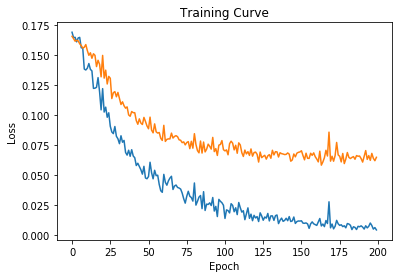

In [0]:
model = pred_LSTM_v2(2240, 1024, 160, 1).cuda()
train_LSTM_network(model, train_data_all, val_data_all, batch_size = 20, num_epochs = 200, lr=0.0001)

0
Epoch 1; Loss 0.168775; Train Acc 0.336424; Val_loss 0.163280; Val Acc 0.350903
1
Epoch 2; Loss 0.160871; Train Acc 0.334942; Val_loss 0.160222; Val Acc 0.358542
2
Epoch 3; Loss 0.164572; Train Acc 0.338113; Val_loss 0.161956; Val Acc 0.346458
3
Epoch 4; Loss 0.167293; Train Acc 0.335359; Val_loss 0.161325; Val Acc 0.347222
4
Epoch 5; Loss 0.169089; Train Acc 0.347755; Val_loss 0.164716; Val Acc 0.351111
5
Epoch 6; Loss 0.158379; Train Acc 0.346609; Val_loss 0.161504; Val Acc 0.354306
6
Epoch 7; Loss 0.152184; Train Acc 0.347222; Val_loss 0.160450; Val Acc 0.348333
7
Epoch 8; Loss 0.161141; Train Acc 0.344120; Val_loss 0.155659; Val Acc 0.356181
8
Epoch 9; Loss 0.161027; Train Acc 0.358229; Val_loss 0.159179; Val Acc 0.358403
9
Epoch 10; Loss 0.155228; Train Acc 0.368843; Val_loss 0.155072; Val Acc 0.370764
10
Epoch 11; Loss 0.150371; Train Acc 0.377419; Val_loss 0.155657; Val Acc 0.373194
11
Epoch 12; Loss 0.167143; Train Acc 0.393530; Val_loss 0.162941; Val Acc 0.369792
12
Epoch 13

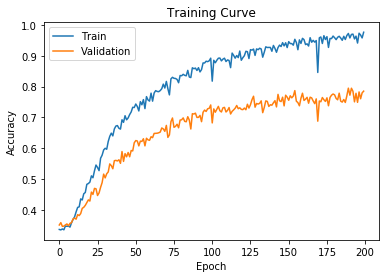

In [0]:
model = pred_LSTM_v2(2240, 1024, 160, 1).cuda()
train_LSTM_network(model, train_data_all, val_data_all, batch_size = 30, num_epochs = 200, lr=0.0001)

In [0]:
model = pred_LSTM_v2(2240, 1024, 160, 1).cuda()
new5 = batched_Data(test_data_all, batch_size=1)
acc5 = get_accuracy(model, new5)

NameError: ignored

In [0]:
import time
def evaluate_validation(model, batch_size, all_data, criterion):
    total_loss = 0.0
    correct = 0.0
    total = 0
    count = 0

    all_data = batched_Data(all_data, batch_size)
    
    for data, labels in all_data:
        count += 1
        output = model(data).cuda()
        labels = labels.cuda()
        loss = criterion(output, labels).cuda()
        #print(loss)
        #print(total_loss)
        total_loss += loss.item()
        
        pred = output
        '''
        print(labels.shape)
        print(output.shape)
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probabilit
        print(pred.shape)
        '''
        for batch in range(batch_size):
            for i,out in enumerate(pred[batch]):
                if out <= 0.33:
                    pred[batch][i] = 0
                elif out >= 0.67:
                    pred[batch][i] = 1
                elif 0.33 < out < 0.67:
                    pred[batch][i] = 0.5
        '''
        print(labels)        
        print(pred)  
        print(labels.view_as(pred))
        print(pred.eq(labels.view_as(pred)))
        '''
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += data.shape[0]*160
    accuracy = correct / total
    loss = total_loss / count
    #print(accuracy, loss)
    return accuracy, loss


def get_accuracy(model, all_data):
    correct, total = 0, 0
    for data, labels in all_data:
        output = model(data).cuda()
        labels = labels.cuda()
        pred = output
        '''
        print(labels.shape)
        print(output.shape)
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probabilit
        print(pred.shape)
        '''
        
        for batch in range(data.shape[0]):
            for i,out in enumerate(pred[batch]):
                if out <= 0.33:
                    pred[batch][i] = 0.0
                elif out >= 0.67:
                    pred[batch][i] = 1.0
                elif 0.33 < out < 0.67:
                    pred[batch][i] = 0.5
        '''
        print(labels)        
        print(pred)  
        print(labels.view_as(pred))
        print(pred.eq(labels.view_as(pred)))
        '''
        correct += pred.eq(labels.view_as(pred)).sum().item()
        #print('correct:{}'.format(correct))
        
        total += data.shape[0]*160
        #print('total:{}'.format(total))
    return correct / total

def batched_Data(data, batch_size):
    dataLen = len(data)
    lenList = [i for i in range(dataLen)]
    random.shuffle(lenList)
    i = 0
    new_tot_list = []
    while i+batch_size <= dataLen:
      new_dataList_per_batch = []
      new_labelList_per_batch = []
      
      for j in range(i,i+batch_size):
          if j == dataLen:
              break
          new_data = data[lenList[j]][0].tolist()
          new_label = data[lenList[j]][1].tolist()
          new_dataList_per_batch.append(new_data)
          new_labelList_per_batch.append(new_label)
      #print(len(new_dataList_per_batch))
      #print(len(new_dataList_per_batch[0]))
      #print(len(new_dataList_per_batch[0][0]))

      new_tot_list += [(torch.tensor(new_dataList_per_batch), torch.tensor(new_labelList_per_batch))]
      i = i+batch_size
    return new_tot_list
    

def train_LSTM_network(model, train, valid, batch_size, num_epochs, lr):
    criterion = nn.MSELoss()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, weight_decay=0.00001)
    #train = torch.utils.data.DataLoader(old_train, batch_size)#, shuffle=True)
    #valid = torch.utils.data.DataLoader(valid, batch_size, shuffle=True)
    losses, train_acc, valid_acc, val_losses = [], [], [], []
    epochs = []
    start = time.time()
    for epoch in range(num_epochs):   # need to be able to do random batch
        print(epoch)
        new_train = batched_Data(train, batch_size)
        for i, (tweets, labels) in enumerate(new_train):
            optimizer.zero_grad()
            pred = model(tweets).cuda()
            labels = labels.cuda()
            #print(labels)
            loss = criterion(pred, labels).cuda()
            loss.backward()
            optimizer.step()

        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, new_train))
        val_acc, val_loss = evaluate_validation(model,  batch_size, valid,criterion)
        val_losses.append(val_loss)
        valid_acc.append(val_acc)
        
        print("Epoch %d; Loss %f; Train Acc %f; Val_loss %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], val_loss, valid_acc[-1]))
    end = time.time()
    print('time: {}'.format(end - start))
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.plot(val_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

0
Epoch 1; Loss 0.169109; Train Acc 0.334815; Val_loss 0.167016; Val Acc 0.342708
1
Epoch 2; Loss 0.170086; Train Acc 0.336111; Val_loss 0.163315; Val Acc 0.346111
2
Epoch 3; Loss 0.164347; Train Acc 0.332188; Val_loss 0.161045; Val Acc 0.349861
3
Epoch 4; Loss 0.161447; Train Acc 0.333565; Val_loss 0.161640; Val Acc 0.343264
4
Epoch 5; Loss 0.155291; Train Acc 0.349537; Val_loss 0.170487; Val Acc 0.345556
5
Epoch 6; Loss 0.155658; Train Acc 0.347338; Val_loss 0.160894; Val Acc 0.362917
6
Epoch 7; Loss 0.154718; Train Acc 0.354653; Val_loss 0.161488; Val Acc 0.356389
7
Epoch 8; Loss 0.156658; Train Acc 0.356308; Val_loss 0.159287; Val Acc 0.354514
8
Epoch 9; Loss 0.150586; Train Acc 0.358611; Val_loss 0.156864; Val Acc 0.356944
9
Epoch 10; Loss 0.163434; Train Acc 0.376331; Val_loss 0.160887; Val Acc 0.376944
10
Epoch 11; Loss 0.148394; Train Acc 0.379363; Val_loss 0.155094; Val Acc 0.371181
11
Epoch 12; Loss 0.149117; Train Acc 0.384074; Val_loss 0.152779; Val Acc 0.377847
12
Epoch 13

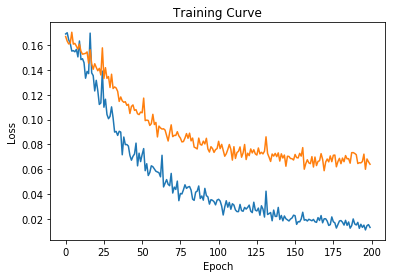

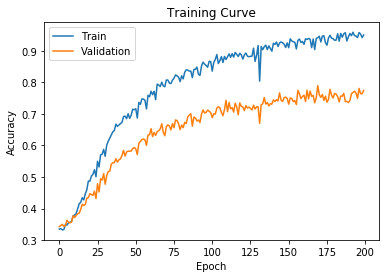

In [0]:
# WITH WEIGHT DECAY
model = pred_LSTM_v2(2240, 1024, 160, 1).cuda()
train_LSTM_network(model, train_data_all, val_data_all, batch_size = 30, num_epochs = 200, lr=0.0001)

0
Epoch 1; Loss 0.170642; Train Acc 0.335475; Val_loss 0.163438; Val Acc 0.347778
1
Epoch 2; Loss 0.163483; Train Acc 0.334062; Val_loss 0.165921; Val Acc 0.335208
2
Epoch 3; Loss 0.161790; Train Acc 0.340336; Val_loss 0.165344; Val Acc 0.342292
3
Epoch 4; Loss 0.157043; Train Acc 0.336238; Val_loss 0.162418; Val Acc 0.345903
4
Epoch 5; Loss 0.158825; Train Acc 0.340475; Val_loss 0.164058; Val Acc 0.338889
5
Epoch 6; Loss 0.160934; Train Acc 0.336447; Val_loss 0.159027; Val Acc 0.351042
6
Epoch 7; Loss 0.157818; Train Acc 0.345509; Val_loss 0.158268; Val Acc 0.358194
7
Epoch 8; Loss 0.145911; Train Acc 0.352998; Val_loss 0.158814; Val Acc 0.362431
8
Epoch 9; Loss 0.155166; Train Acc 0.348935; Val_loss 0.159712; Val Acc 0.349861
9
Epoch 10; Loss 0.165926; Train Acc 0.366759; Val_loss 0.160274; Val Acc 0.367222
10
Epoch 11; Loss 0.154688; Train Acc 0.377859; Val_loss 0.156363; Val Acc 0.373194
11
Epoch 12; Loss 0.151056; Train Acc 0.383090; Val_loss 0.157577; Val Acc 0.367917
12
Epoch 13

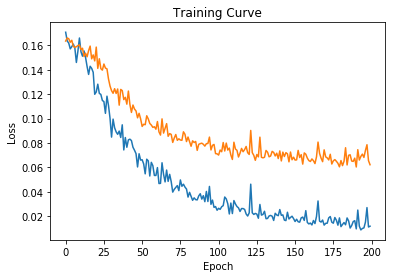

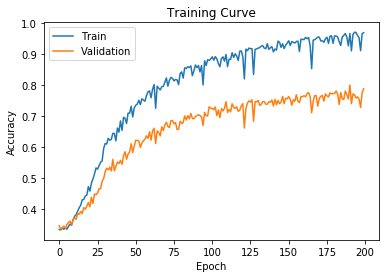

In [0]:
#WITH WEIGHT DECAY
model = pred_LSTM_v2(2240, 1256, 160, 1).cuda()
train_LSTM_network(model, train_data_all, val_data_all, batch_size = 30, num_epochs = 200, lr=0.0001)

In [0]:
new1 = batched_Data(test_data_all, batch_size=1)
acc1 = get_accuracy(model, new1)

In [0]:
class pred_GRU_v1(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, batch_size):
        super(pred_GRU_v1, self).__init__()
        #self.emb = --> from the data function, the data come in in right shape
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.lstm = nn.GRU(input_size, hidden_size, batch_first = True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self,x):
        # Format to be proper input pf shape [batch_zise, seq = 25, size = 162*11]
        #inp = self.emb(x) --> from the data function, the data come in in right shape
        inp = x.cuda()
        # Shape of the hidden layer and cell state should have 
        # shape of [batch_size, sequence length(25), hidden_size]
        h0 = torch.zeros(self.batch_size, x.size(0), self.hidden_size).cuda()
        
        #Shape of the LSTM output will be [batch_size, sequence length(25), hidden_size]
        out, h_new = self.lstm(inp, h0)
        out = self.fc(out[:,-1,:]).cuda()
        return out

0
Epoch 1; Loss 0.174891; Train Acc 0.349977; Val_loss 0.167861; Val Acc 0.359028
1
Epoch 2; Loss 0.163125; Train Acc 0.347581; Val_loss 0.163547; Val Acc 0.366250
2
Epoch 3; Loss 0.168231; Train Acc 0.347616; Val_loss 0.165672; Val Acc 0.351111
3
Epoch 4; Loss 0.171904; Train Acc 0.343565; Val_loss 0.164061; Val Acc 0.352569
4
Epoch 5; Loss 0.170186; Train Acc 0.359190; Val_loss 0.168482; Val Acc 0.362708
5
Epoch 6; Loss 0.159389; Train Acc 0.365590; Val_loss 0.164656; Val Acc 0.364444
6
Epoch 7; Loss 0.154673; Train Acc 0.370648; Val_loss 0.164098; Val Acc 0.365556
7
Epoch 8; Loss 0.161055; Train Acc 0.368264; Val_loss 0.158177; Val Acc 0.369306
8
Epoch 9; Loss 0.162624; Train Acc 0.373519; Val_loss 0.161287; Val Acc 0.370347
9
Epoch 10; Loss 0.156518; Train Acc 0.386007; Val_loss 0.157014; Val Acc 0.379375
10
Epoch 11; Loss 0.150864; Train Acc 0.396053; Val_loss 0.158428; Val Acc 0.384028
11
Epoch 12; Loss 0.173790; Train Acc 0.396852; Val_loss 0.172604; Val Acc 0.364097
12
Epoch 13

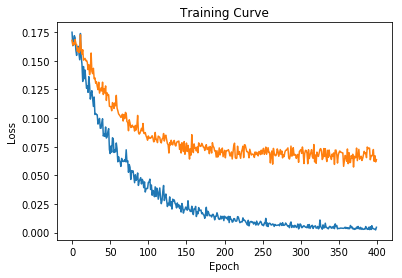

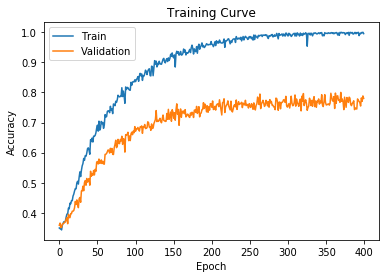

In [0]:
model = pred_GRU_v1(2240, 1256, 160, 1).cuda()
train_LSTM_network(model, train_data_all, val_data_all, batch_size = 30, num_epochs = 400, lr=0.0001)

0
Epoch 1; Loss 0.169336; Train Acc 0.333877; Val_loss 0.165279; Val Acc 0.347778
1
Epoch 2; Loss 0.161102; Train Acc 0.336875; Val_loss 0.163938; Val Acc 0.348403
2
Epoch 3; Loss 0.175166; Train Acc 0.334641; Val_loss 0.161300; Val Acc 0.352917
3
Epoch 4; Loss 0.161404; Train Acc 0.335012; Val_loss 0.161190; Val Acc 0.349653
4
Epoch 5; Loss 0.161522; Train Acc 0.339294; Val_loss 0.163663; Val Acc 0.343611
5
Epoch 6; Loss 0.173919; Train Acc 0.341435; Val_loss 0.161220; Val Acc 0.348472
6
Epoch 7; Loss 0.160282; Train Acc 0.349491; Val_loss 0.160555; Val Acc 0.358333
7
Epoch 8; Loss 0.157981; Train Acc 0.358380; Val_loss 0.161087; Val Acc 0.359514
8
Epoch 9; Loss 0.163066; Train Acc 0.363067; Val_loss 0.161626; Val Acc 0.367569
9
Epoch 10; Loss 0.146775; Train Acc 0.368727; Val_loss 0.160463; Val Acc 0.363264
10
Epoch 11; Loss 0.157903; Train Acc 0.382928; Val_loss 0.170018; Val Acc 0.366944
11
Epoch 12; Loss 0.151836; Train Acc 0.370081; Val_loss 0.155399; Val Acc 0.368264
12
Epoch 13

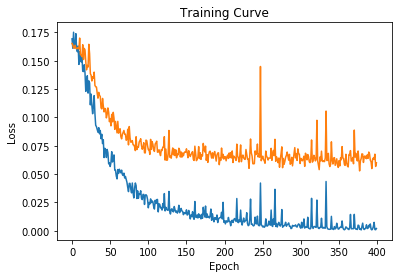

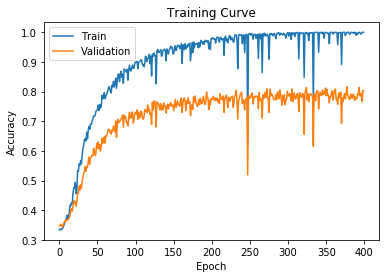

In [0]:
# WITH weight decay 
model = pred_LSTM_v2(2240, 1500, 160, 1).cuda()
train_LSTM_network(model, train_data_all, val_data_all, batch_size = 30, num_epochs = 400, lr=0.0001)

In [0]:
def train_LSTM_network(model, train, valid, batch_size, num_epochs, lr):
    criterion = nn.MSELoss()
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    #train = torch.utils.data.DataLoader(old_train, batch_size)#, shuffle=True)
    #valid = torch.utils.data.DataLoader(valid, batch_size, shuffle=True)
    losses, train_acc, valid_acc, val_losses = [], [], [], []
    epochs = []
    start = time.time()
    for epoch in range(num_epochs):   # need to be able to do random batch
        print(epoch)
        new_train = batched_Data(train, batch_size)
        for i, (tweets, labels) in enumerate(new_train):
            optimizer.zero_grad()
            pred = model(tweets).cuda()
            labels = labels.cuda()
            #print(labels)
            loss = criterion(pred, labels).cuda()
            loss.backward()
            optimizer.step()

        losses.append(float(loss))

        epochs.append(epoch)
        train_acc.append(get_accuracy(model, new_train))
        val_acc, val_loss = evaluate_validation(model,  batch_size, valid,criterion)
        val_losses.append(val_loss)
        valid_acc.append(val_acc)
        
        print("Epoch %d; Loss %f; Train Acc %f; Val_loss %f; Val Acc %f" % (
              epoch+1, loss, train_acc[-1], val_loss, valid_acc[-1]))
    end = time.time()
    print('time: {}'.format(end - start))
    # plotting
    plt.title("Training Curve")
    plt.plot(losses, label="Train")
    plt.plot(val_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

0
Epoch 1; Loss 0.158056; Train Acc 0.335544; Val_loss 0.166314; Val Acc 0.347438
1
Epoch 2; Loss 0.169601; Train Acc 0.337755; Val_loss 0.164360; Val Acc 0.349562
2
Epoch 3; Loss 0.162140; Train Acc 0.337593; Val_loss 0.162208; Val Acc 0.354750
3
Epoch 4; Loss 0.166256; Train Acc 0.338264; Val_loss 0.162072; Val Acc 0.348062
4
Epoch 5; Loss 0.159245; Train Acc 0.340116; Val_loss 0.160802; Val Acc 0.354938
5
Epoch 6; Loss 0.162509; Train Acc 0.343935; Val_loss 0.159251; Val Acc 0.355625
6
Epoch 7; Loss 0.147432; Train Acc 0.358032; Val_loss 0.159177; Val Acc 0.362812
7
Epoch 8; Loss 0.160153; Train Acc 0.369873; Val_loss 0.157002; Val Acc 0.372312
8
Epoch 9; Loss 0.141843; Train Acc 0.379225; Val_loss 0.157743; Val Acc 0.364187
9
Epoch 10; Loss 0.151300; Train Acc 0.386111; Val_loss 0.156494; Val Acc 0.376875
10
Epoch 11; Loss 0.155409; Train Acc 0.408310; Val_loss 0.161433; Val Acc 0.393813
11
Epoch 12; Loss 0.150534; Train Acc 0.408495; Val_loss 0.163847; Val Acc 0.388000
12
Epoch 13

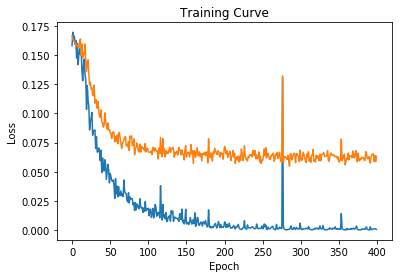

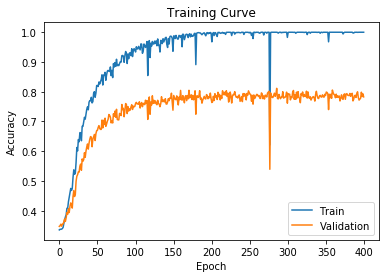

In [0]:
# Without weight decay
model = pred_LSTM_v2(2240, 1500, 160, 1).cuda()
train_LSTM_network(model, train_data_all, val_data_all, batch_size = 20, num_epochs = 400, lr=0.0001)

In [0]:
new2 = batched_Data(test_data_all, batch_size=1)
acc2 = get_accuracy(model, new2)

In [0]:
acc2

0.7953645833333334

0
Epoch 1; Loss 0.158212; Train Acc 0.340259; Val_loss 0.165916; Val Acc 0.347798
1
Epoch 2; Loss 0.165448; Train Acc 0.338288; Val_loss 0.163775; Val Acc 0.348333
2
Epoch 3; Loss 0.160124; Train Acc 0.339313; Val_loss 0.162123; Val Acc 0.350238
3
Epoch 4; Loss 0.150025; Train Acc 0.344797; Val_loss 0.163289; Val Acc 0.351429
4
Epoch 5; Loss 0.172522; Train Acc 0.345383; Val_loss 0.160614; Val Acc 0.354881
5
Epoch 6; Loss 0.153153; Train Acc 0.355495; Val_loss 0.159554; Val Acc 0.357500
6
Epoch 7; Loss 0.157370; Train Acc 0.366340; Val_loss 0.157321; Val Acc 0.367738
7
Epoch 8; Loss 0.150883; Train Acc 0.383705; Val_loss 0.158098; Val Acc 0.366310
8
Epoch 9; Loss 0.140299; Train Acc 0.408559; Val_loss 0.169338; Val Acc 0.376429
9
Epoch 10; Loss 0.137099; Train Acc 0.418919; Val_loss 0.153378; Val Acc 0.387738
10
Epoch 11; Loss 0.134098; Train Acc 0.426779; Val_loss 0.148661; Val Acc 0.394821
11
Epoch 12; Loss 0.130096; Train Acc 0.455957; Val_loss 0.152568; Val Acc 0.407679
12
Epoch 13

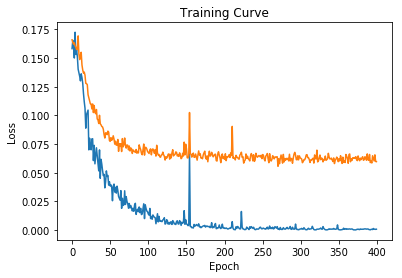

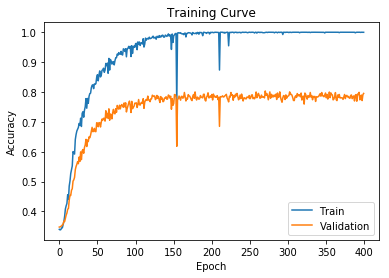

In [0]:
# Without weight decay
model = pred_LSTM_v2(2240, 1500, 160, 1).cuda()
train_LSTM_network(model, train_data_all, val_data_all, batch_size = 15, num_epochs = 400, lr=0.0001)

In [0]:
new4 = batched_Data(test_data_all, batch_size=1)
acc4 = get_accuracy(model, new4)

In [0]:
acc4

0.79

0
Epoch 1; Loss 0.178751; Train Acc 0.338142; Val_loss 0.164277; Val Acc 0.350119
1
Epoch 2; Loss 0.157409; Train Acc 0.336385; Val_loss 0.161097; Val Acc 0.350060
2
Epoch 3; Loss 0.168750; Train Acc 0.335372; Val_loss 0.164027; Val Acc 0.340238
3
Epoch 4; Loss 0.152782; Train Acc 0.345101; Val_loss 0.162307; Val Acc 0.351726
4
Epoch 5; Loss 0.156800; Train Acc 0.348401; Val_loss 0.161811; Val Acc 0.351488
5
Epoch 6; Loss 0.156231; Train Acc 0.357635; Val_loss 0.159256; Val Acc 0.360952
6
Epoch 7; Loss 0.150176; Train Acc 0.372275; Val_loss 0.158011; Val Acc 0.364821
7
Epoch 8; Loss 0.175503; Train Acc 0.389966; Val_loss 0.160923; Val Acc 0.378512
8
Epoch 9; Loss 0.169848; Train Acc 0.386881; Val_loss 0.154661; Val Acc 0.366786
9
Epoch 10; Loss 0.138158; Train Acc 0.425124; Val_loss 0.149557; Val Acc 0.401131
10
Epoch 11; Loss 0.141429; Train Acc 0.429887; Val_loss 0.149016; Val Acc 0.397798
11
Epoch 12; Loss 0.124192; Train Acc 0.458457; Val_loss 0.146123; Val Acc 0.414286
12
Epoch 13

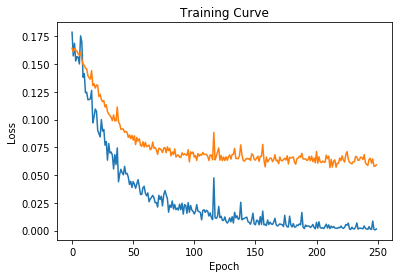

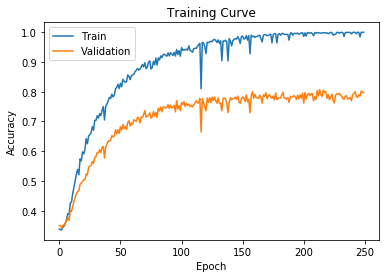

In [0]:
# Without weight decay
model = pred_LSTM_v2(2240, 1024, 160, 1).cuda()
train_LSTM_network(model, train_data_all, val_data_all, batch_size = 15, num_epochs = 250, lr=0.0001)

In [0]:
new3 = batched_Data(test_data_all, batch_size=1)
acc3 = get_accuracy(model, new3)

In [0]:
acc3

0.79390625

0
Epoch 1; Loss 0.167646; Train Acc 0.347083; Val_loss 0.172652; Val Acc 0.355595
1
Epoch 2; Loss 0.166909; Train Acc 0.339775; Val_loss 0.163540; Val Acc 0.349821
2
Epoch 3; Loss 0.165409; Train Acc 0.340721; Val_loss 0.164538; Val Acc 0.350357
3
Epoch 4; Loss 0.154786; Train Acc 0.339381; Val_loss 0.162231; Val Acc 0.346667
4
Epoch 5; Loss 0.153982; Train Acc 0.343694; Val_loss 0.161165; Val Acc 0.353036
5
Epoch 6; Loss 0.149593; Train Acc 0.356092; Val_loss 0.159227; Val Acc 0.360833
6
Epoch 7; Loss 0.152840; Train Acc 0.353322; Val_loss 0.158324; Val Acc 0.359643
7
Epoch 8; Loss 0.147896; Train Acc 0.361464; Val_loss 0.156858; Val Acc 0.358988
8
Epoch 9; Loss 0.155152; Train Acc 0.370856; Val_loss 0.153409; Val Acc 0.371250
9
Epoch 10; Loss 0.155415; Train Acc 0.379538; Val_loss 0.153878; Val Acc 0.375595
10
Epoch 11; Loss 0.133479; Train Acc 0.405338; Val_loss 0.157443; Val Acc 0.399405
11
Epoch 12; Loss 0.148468; Train Acc 0.403052; Val_loss 0.153094; Val Acc 0.375238
12
Epoch 13

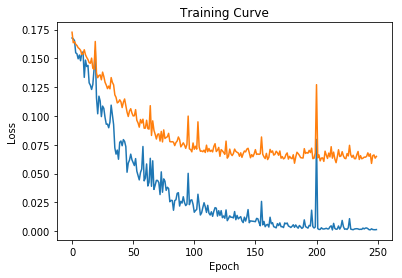

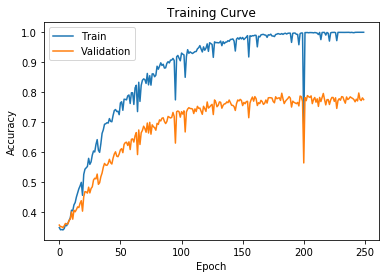

In [0]:
# Without weight decay
model = pred_LSTM_v2(2240, 1024, 160, 1).cuda()
train_LSTM_network(model, train_data_all, val_data_all, batch_size = 15, num_epochs = 250, lr=0.0002)

In [0]:
# with 14 instead 11 
class pred_LSTM_v3(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, batch_size):
        super(pred_LSTM_v3, self).__init__()
        #self.emb = --> from the data function, the data come in in right shape
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first = True)
        self.fc1 = nn.Linear(hidden_size, 256)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(256, num_classes)
        
        
    def forward(self,x):
        # Format to be proper input pf shape [batch_zise, seq = 25, size = 162*11]
        #inp = self.emb(x) --> from the data function, the data come in in right shape
        inp = x.cuda()
        # Shape of the hidden layer and cell state should have 
        # shape of [batch_size, sequence length(25), hidden_size]
        h0 = torch.zeros(self.batch_size, x.size(0), self.hidden_size).cuda()
        c0 = torch.zeros(self.batch_size, x.size(0),  self.hidden_size).cuda()
        
        #Shape of the LSTM output will be [batch_size, sequence length(25), hidden_size]
        out, (h_new, c_new) = self.lstm(inp, (h0,c0))
        out1 = self.relu(self.fc1(out[:,-1,:])).cuda()
        out = self.fc2(out1)

        return out
        

In [0]:
new = batched_Data(test_data_all, batch_size=1)
acc = get_accuracy(model, new)

In [0]:
acc

0.6615104166666667

In [0]:

model = pred_LSTM_v2(2240, 224, 160, 1).cuda()
train_LSTM_network(model, train_data_all, val_data_all, batch_size = 20, num_epochs = 200, lr=0.0002)

In [0]:
=========================== Don't look at code Below ======================

In [0]:
new = batched_Data(test_data_all, batch_size=1)
len(new)
new[0][0].shape

torch.Size([1, 25, 1760])

In [0]:
new = batched_Data(test_data_all, batch_size=1)
acc = get_accuracy(model, new)

In [0]:
acc

54.8

In [0]:
class pred_GRU_v1(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, batch_size):
        super(pred_GRU_v1, self).__init__()
        #self.emb = --> from the data function, the data come in in right shape
        self.hidden_size = hidden_size
        self.batch_size = batch_size
        self.lstm = nn.GRU(input_size, hidden_size, batch_first = True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self,x):
        # Format to be proper input pf shape [batch_zise, seq = 25, size = 162*11]
        #inp = self.emb(x) --> from the data function, the data come in in right shape
        inp = x.cuda()
        # Shape of the hidden layer and cell state should have 
        # shape of [batch_size, sequence length(25), hidden_size]
        h0 = torch.zeros(self.batch_size, x.size(0), self.hidden_size).cuda()
        
        #Shape of the LSTM output will be [batch_size, sequence length(25), hidden_size]
        out, h_new = self.lstm(inp, h0)
        out = self.fc(out[:,-1,:]).cuda()
        return out

0
Epoch 1; Loss 0.171108; Train Acc 0.334456; Val_loss 0.166121; Val Acc 0.347000
1
Epoch 2; Loss 0.164802; Train Acc 0.337442; Val_loss 0.164562; Val Acc 0.344875
2
Epoch 3; Loss 0.163552; Train Acc 0.335625; Val_loss 0.162486; Val Acc 0.350125
3
Epoch 4; Loss 0.159686; Train Acc 0.339375; Val_loss 0.162789; Val Acc 0.351313
4
Epoch 5; Loss 0.166088; Train Acc 0.342951; Val_loss 0.162662; Val Acc 0.350125
5
Epoch 6; Loss 0.170096; Train Acc 0.339606; Val_loss 0.161529; Val Acc 0.348000
6
Epoch 7; Loss 0.158719; Train Acc 0.348438; Val_loss 0.160448; Val Acc 0.357375
7
Epoch 8; Loss 0.163537; Train Acc 0.350880; Val_loss 0.159953; Val Acc 0.356750
8
Epoch 9; Loss 0.153109; Train Acc 0.356470; Val_loss 0.160422; Val Acc 0.364063
9
Epoch 10; Loss 0.147914; Train Acc 0.365116; Val_loss 0.163303; Val Acc 0.357438
10
Epoch 11; Loss 0.149854; Train Acc 0.362407; Val_loss 0.159827; Val Acc 0.362063
11
Epoch 12; Loss 0.155463; Train Acc 0.355671; Val_loss 0.156967; Val Acc 0.360500
12
Epoch 13

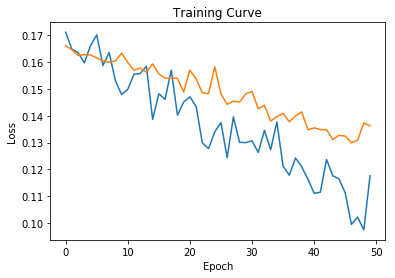

In [0]:
# with rms parameters
model = pred_GRU_v1(2240, 200, 160, 1).cuda()
train_LSTM_network(model, train_data_all, val_data_all, batch_size = 20, num_epochs = 50, lr=0.0001)

0
Epoch 1; Loss 0.178491; Train Acc 0.341019; Val_loss 0.166646; Val Acc 0.354938
1
Epoch 2; Loss 0.169257; Train Acc 0.353900; Val_loss 0.169992; Val Acc 0.354812
2
Epoch 3; Loss 0.172749; Train Acc 0.351192; Val_loss 0.163270; Val Acc 0.357375
3
Epoch 4; Loss 0.164074; Train Acc 0.354282; Val_loss 0.161813; Val Acc 0.368125
4
Epoch 5; Loss 0.163476; Train Acc 0.367928; Val_loss 0.163398; Val Acc 0.366563
5
Epoch 6; Loss 0.159751; Train Acc 0.378993; Val_loss 0.161281; Val Acc 0.377125
6
Epoch 7; Loss 0.147308; Train Acc 0.387002; Val_loss 0.160916; Val Acc 0.372312
7
Epoch 8; Loss 0.151931; Train Acc 0.402894; Val_loss 0.164483; Val Acc 0.375188
8
Epoch 9; Loss 0.151053; Train Acc 0.401562; Val_loss 0.169084; Val Acc 0.366187
9
Epoch 10; Loss 0.136258; Train Acc 0.410660; Val_loss 0.153885; Val Acc 0.388562
10
Epoch 11; Loss 0.142250; Train Acc 0.418519; Val_loss 0.154095; Val Acc 0.390000
11
Epoch 12; Loss 0.140366; Train Acc 0.436968; Val_loss 0.154370; Val Acc 0.395688
12
Epoch 13

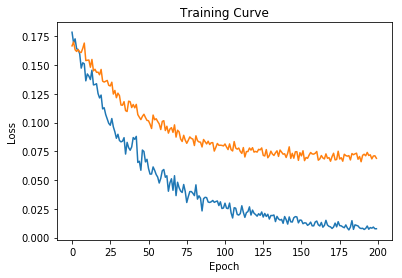

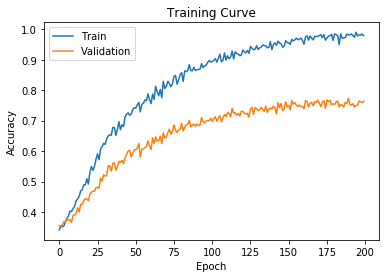

In [0]:
# with rms parameters
model = pred_GRU_v1(2240, 1256, 160, 1).cuda()
train_LSTM_network(model, train_data_all, val_data_all, batch_size = 20, num_epochs = 200, lr=0.0001)